In [395]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate

# Unsupervised Learning

Unsupervised learning - Apply unsupervised learning to explore whether the \
intrinsic structure of the gene expression data naturally reflects the known \
cancer subtypes. Use dimensionality reduction techniques (e.g PCA or UMAP) for \
visualization and clustering algorithms (e.g K-means, hierarchical clustering). \
Are the subtypes of cancer (Classical and Mesenchymal) recapitulated using these \
methods? Generate visualizations using the results from these methods.

In [396]:
# Load your gene expression dataset
# Assume `X` is the gene expression matrix (samples x genes)
# and `labels` contains known subtypes: ['Classical', 'Mesenchymal']
X = pd.read_csv("datasets/X_gexp.csv", index_col=0)
labels = pd.read_csv("datasets/y_gexp.csv", index_col=0).values.ravel()

# Standardize
X_std = (X - X.mean()) / X.std()

# --------------------
# Dimensionality Reduction
# --------------------
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_std)


/Users/gdsantos/Desktop/University/MCC/2A_2S/Bioinformática/Group_Assignment_2/bioinformatics_ml/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gdsantos/Desktop/University/MCC/2A_2S/Bioinformática/Group_Assignment_2/bioinformatics_ml/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [397]:
# --------------------
# Clustering
# --------------------
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_std)

hierarchical = AgglomerativeClustering(n_clusters=2)
hier_labels = hierarchical.fit_predict(X_std)

In [398]:
# --------------------
# Evaluation (if labels known)
# --------------------
ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(labels, kmeans_labels)

ari_hier = adjusted_rand_score(labels, hier_labels)
nmi_hier = normalized_mutual_info_score(labels, hier_labels)

print(f"KMeans - ARI: {ari_kmeans:.2f}, NMI: {nmi_kmeans:.2f}")
print(f"Hierarchical - ARI: {ari_hier:.2f}, NMI: {nmi_hier:.2f}")



KMeans - ARI: 0.04, NMI: 0.03
Hierarchical - ARI: 0.00, NMI: 0.00


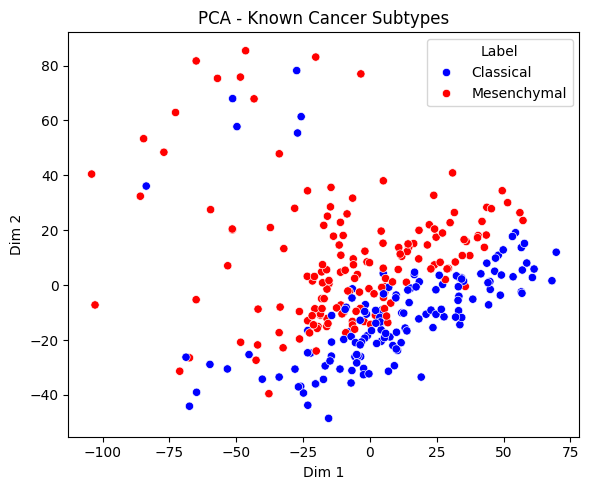

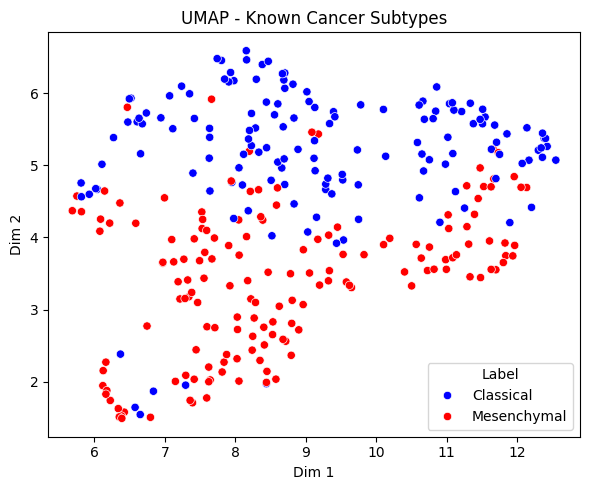

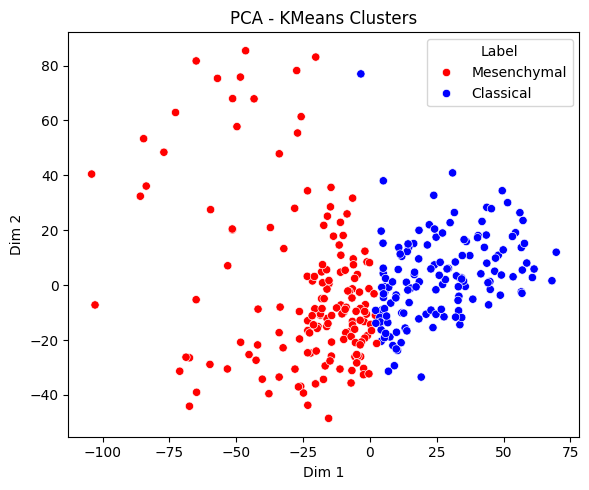

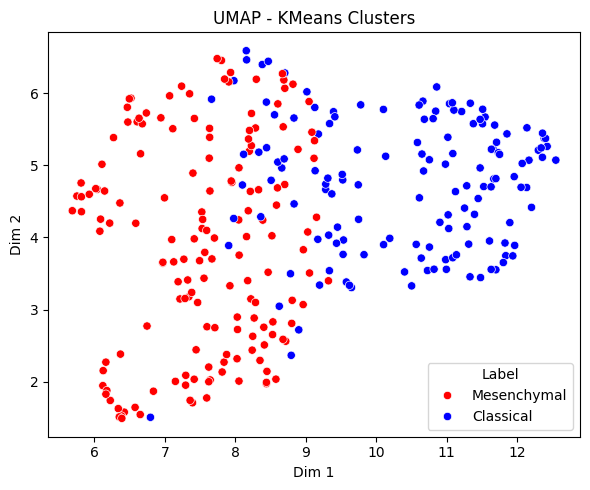

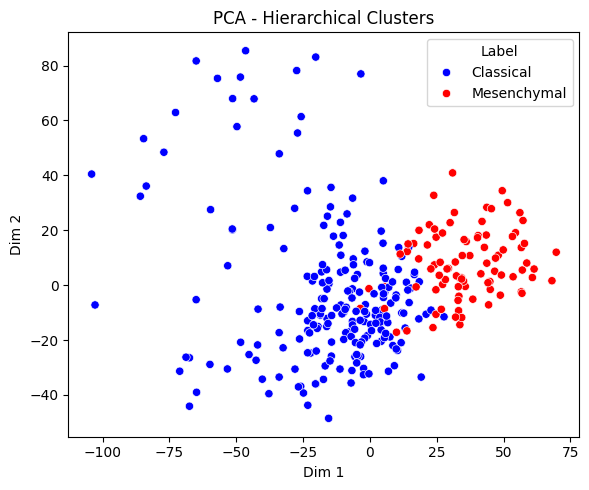

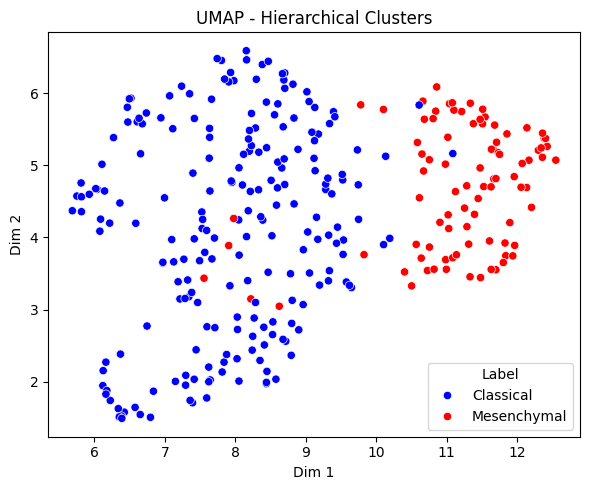

In [399]:
# --------------------
# Visualization
# --------------------
def plot_embedding(X_embed, labels, title, is_subtype=False):
    plt.figure(figsize=(6,5))
    
    if is_subtype:
        # Map 0 → Classical, 1 → Mesenchymal
        label_names = np.array(["Classical", "Mesenchymal"])
        labels_named = label_names[labels]
        palette = {"Classical": "blue", "Mesenchymal": "red"}
    else:
        labels_named = labels
        palette = sns.color_palette("Set1", n_colors=len(np.unique(labels)))
    
    sns.scatterplot(x=X_embed[:, 0], y=X_embed[:, 1], hue=labels_named, palette=palette)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()

# Plot PCA / UMAP colored by known subtypes
plot_embedding(X_pca, labels, "PCA - Known Cancer Subtypes", is_subtype=True)
plot_embedding(X_umap, labels, "UMAP - Known Cancer Subtypes", is_subtype=True)

# Plot PCA / UMAP colored by KMeans clusters
plot_embedding(X_pca, kmeans_labels, "PCA - KMeans Clusters", is_subtype=True)
plot_embedding(X_umap, kmeans_labels, "UMAP - KMeans Clusters", is_subtype=True)

# Plot PCA / UMAP colored by Hierarchical Clusters
plot_embedding(X_pca, hier_labels, "PCA - Hierarchical Clusters", is_subtype=True)
plot_embedding(X_umap, hier_labels, "UMAP - Hierarchical Clusters", is_subtype=True)

# Supervised Learning

Build a binary classifier capable of distinguishing between the Classical \
(prognostically favourable) and Mesenchymal (prognostically adverse) subtypes. \
A possible pipeline for this task is outlined below and should guide you in building \
and evaluating your subtype classification model using gene expression data

## Data Preprocessing

Loading data 
Encoding data

In [400]:
# --------------------
# Load Data
# --------------------
X = pd.read_csv("datasets/X_gexp.csv", index_col=0)
y = pd.read_csv("datasets/y_gexp.csv", index_col=0).values.ravel()

## Train and Test Split

In [401]:
# --------------------
# Train-Test Split
# --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

Selecting the most relevants features

/var/folders/7_/dhch1whn1nvc26xrz2l7ycjm0000gn/T/ipykernel_37028/620794465.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["Subtype"] = y_train  # adicionar as labels para separação no gráfico


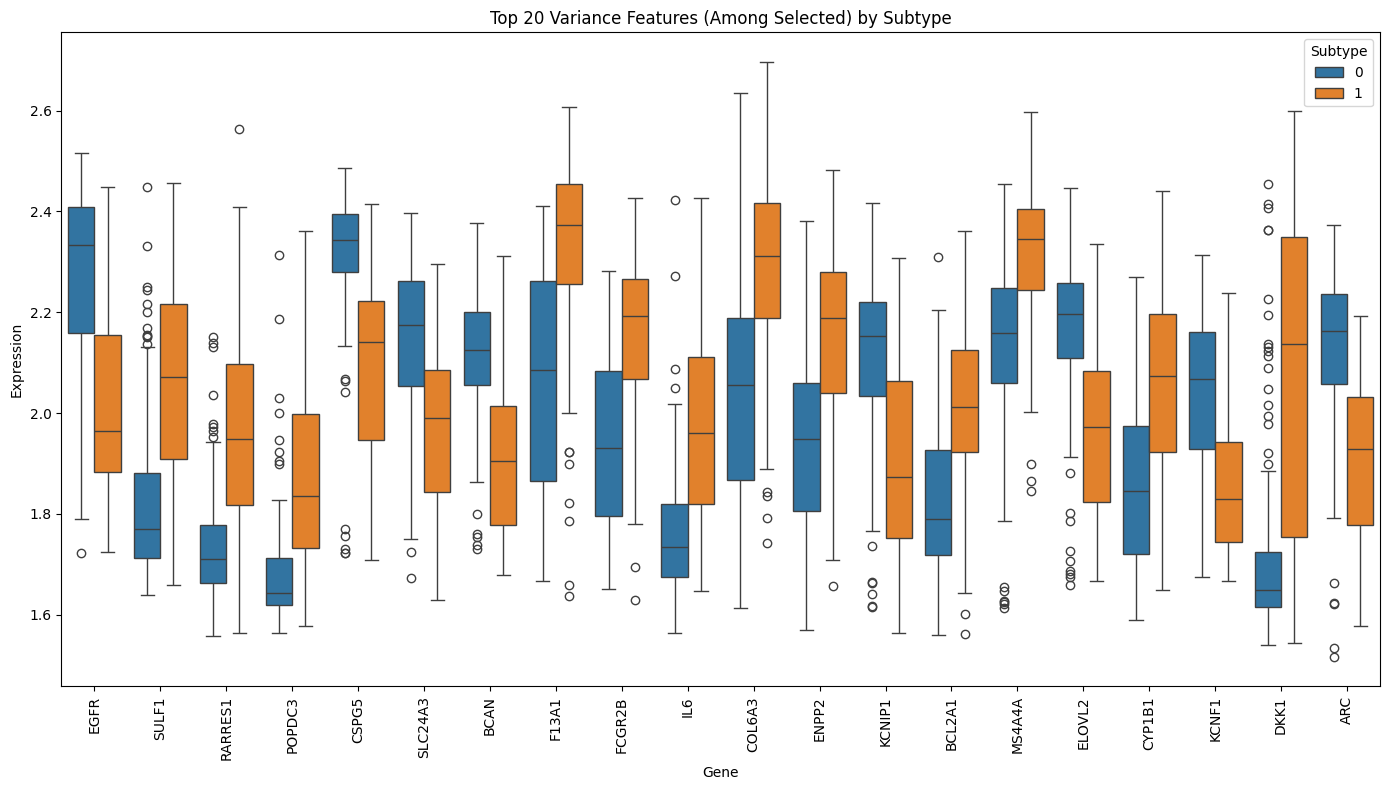


Top 20 Feature Importances (Random Forest):
    Feature  Importance
99     CTSC    0.062522
25     CSTA    0.054649
46    WSCD1    0.053962
28    CSPG5    0.042709
13      CKB    0.038597
9     IL1R1    0.035760
35     BCAN    0.032439
93      ARC    0.031954
29    SEZ6L    0.029393
42  TNFAIP8    0.028043
41    IFI30    0.027856
20     CTSH    0.020807
40     DAB2    0.018749
83    VAMP8    0.018001
59     AIF1    0.017281
17   SLAMF8    0.014235
50     GAS1    0.014091
7   RARRES1    0.013273
73   KCNIP1    0.012789
98     SGEF    0.012487


/var/folders/7_/dhch1whn1nvc26xrz2l7ycjm0000gn/T/ipykernel_37028/620794465.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20), palette="viridis")


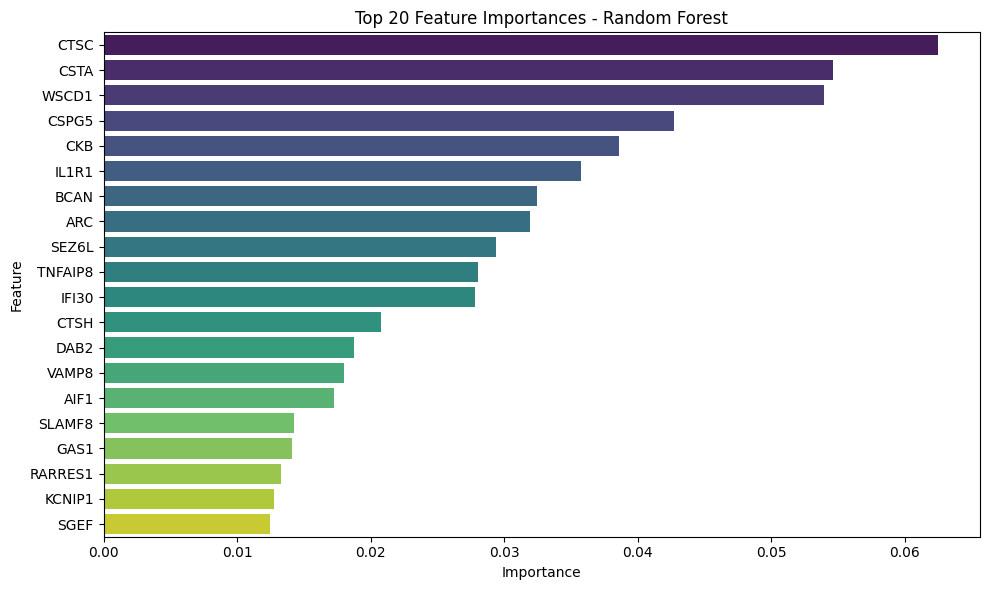

In [402]:
# --------------------
# Feature Selection on Training Data
# --------------------
vt = VarianceThreshold(threshold=0.01)
X_train_vt = vt.fit_transform(X_train)
X_test_vt = vt.transform(X_test)

# Obter os nomes das features após o VarianceThreshold
vt_feature_names = X_train.columns[vt.get_support()]
X_train_vt_df = pd.DataFrame(X_train_vt, columns=vt_feature_names)

# Selecionar as top 100 features com ANOVA F-test
select_k = 100
fs = SelectKBest(score_func=f_classif, k=select_k)
X_train_selected = fs.fit_transform(X_train_vt_df, y_train)
X_test_selected = fs.transform(pd.DataFrame(X_test_vt, columns=vt_feature_names))

# Obter os nomes das 100 features selecionadas
selected_feature_names = vt_feature_names[fs.get_support()]

# --------------------
# Visualização: Boxplot das features selecionadas
# --------------------
selected_df = X_train_vt_df[selected_feature_names]
selected_df["Subtype"] = y_train  # adicionar as labels para separação no gráfico

# Converter de wide para long format para facilitar o uso com seaborn
long_df = pd.melt(selected_df, id_vars="Subtype", var_name="Gene", value_name="Expression")

# Plotar as top 20 features com maior variância para facilitar visualização
top20_genes = selected_df.drop(columns="Subtype").var().sort_values(ascending=False).head(20).index
top20_df = long_df[long_df["Gene"].isin(top20_genes)]

plt.figure(figsize=(14, 8))
sns.boxplot(data=top20_df, x="Gene", y="Expression", hue="Subtype")
plt.xticks(rotation=90)
plt.title("Top 20 Variance Features (Among Selected) by Subtype")
plt.tight_layout()
plt.show()


# --------------------
# Random Forest Feature Importance
# --------------------

# Recuperar os nomes das features após seleção
# Passo 1: aplicar VarianceThreshold nos nomes
vt_feature_names = X.columns[vt.get_support()]

# Passo 2: aplicar SelectKBest nos nomes restantes
selected_feature_names = vt_feature_names[fs.get_support()]

# Treinar Random Forest no conjunto de treino
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)

# Obter importâncias
importances = rf.feature_importances_

# Criar DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar top 20
print("\nTop 20 Feature Importances (Random Forest):")
print(feature_importance_df.head(20))

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20), palette="viridis")
plt.title("Top 20 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()



In [403]:
# --------------------
# Standardization
# --------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# --------------------
# Classifier
# --------------------
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

In [404]:
# --------------------
# Evaluation
# --------------------
print("Logistic Regression - Test Evaluation:")
print(classification_report(y_test, y_pred, target_names=["Classical", "Mesenchymal"]))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

Logistic Regression - Test Evaluation:
              precision    recall  f1-score   support

   Classical       0.90      0.97      0.93        29
 Mesenchymal       0.97      0.91      0.94        32

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61

ROC AUC: 0.989


In [405]:
# --------------------
# Set up scorers for CV on train
# --------------------
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [406]:
# --------------------
# Classifier 1: Logistic Regression - CV on train
# --------------------
log_reg_results = []
for C in [0.01, 0.1, 1, 10]:
    pipeline = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=300)),
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(C=C, max_iter=1000))
    ])
    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
    log_reg_results.append({
        'Model': f'LogReg (C={C})',
        **{metric: f"{np.mean(scores[f'test_{metric}']):.3f} ± {np.std(scores[f'test_{metric}']):.3f}"
           for metric in scoring}
    })

** Random Forest **

In [407]:
# --------------------
# Classifier 2: Random Forest - CV on train
# --------------------
rf_results = []
for n_estimators in [50, 100]:
    for max_depth in [None, 10, 20]:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=f_classif, k=300)),
            ('clf', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42))
        ])
        scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
        rf_results.append({
            'Model': f'RF (n={n_estimators}, depth={max_depth})',
            **{metric: f"{np.mean(scores[f'test_{metric}']):.3f} ± {np.std(scores[f'test_{metric}']):.3f}"
               for metric in scoring}
        })

In [408]:
# --------------------
# Display CV Results
# --------------------
results_df = pd.DataFrame(log_reg_results + rf_results)
print("\nCross-Validation Results (Train Set):")
print(results_df)


Cross-Validation Results (Train Set):
                    Model       accuracy      precision         recall  \
0         LogReg (C=0.01)  0.921 ± 0.015  0.919 ± 0.053  0.936 ± 0.041   
1          LogReg (C=0.1)  0.934 ± 0.015  0.931 ± 0.037  0.944 ± 0.020   
2            LogReg (C=1)  0.934 ± 0.015  0.931 ± 0.037  0.944 ± 0.020   
3           LogReg (C=10)  0.934 ± 0.016  0.937 ± 0.031  0.936 ± 0.020   
4   RF (n=50, depth=None)  0.930 ± 0.044  0.918 ± 0.055  0.952 ± 0.047   
5     RF (n=50, depth=10)  0.930 ± 0.044  0.918 ± 0.055  0.952 ± 0.047   
6     RF (n=50, depth=20)  0.930 ± 0.044  0.918 ± 0.055  0.952 ± 0.047   
7  RF (n=100, depth=None)  0.934 ± 0.036  0.918 ± 0.047  0.960 ± 0.036   
8    RF (n=100, depth=10)  0.934 ± 0.036  0.918 ± 0.047  0.960 ± 0.036   
9    RF (n=100, depth=20)  0.934 ± 0.036  0.918 ± 0.047  0.960 ± 0.036   

              f1  
0  0.925 ± 0.012  
1  0.937 ± 0.014  
2  0.937 ± 0.014  
3  0.936 ± 0.015  
4  0.934 ± 0.042  
5  0.934 ± 0.042  
6  0.934 ± 0.